In [243]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import numpyro
import numpy as np 

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive





In [244]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]
    print(selected_tracks[0])

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), np.concatenate(yini).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, G_GAIA, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), np.concatenate(MeH).reshape(-1, 1)])



track07294


In [245]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [246]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V3_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Dell\AppData\Local\Temp\ipykernel_27372\3765155684.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V3_state.pth

[ 4.0303917  -1.5210836   2.6623778   0.7221201  -0.14469111  2.535521
 -0.84647286 -1.172303  ]


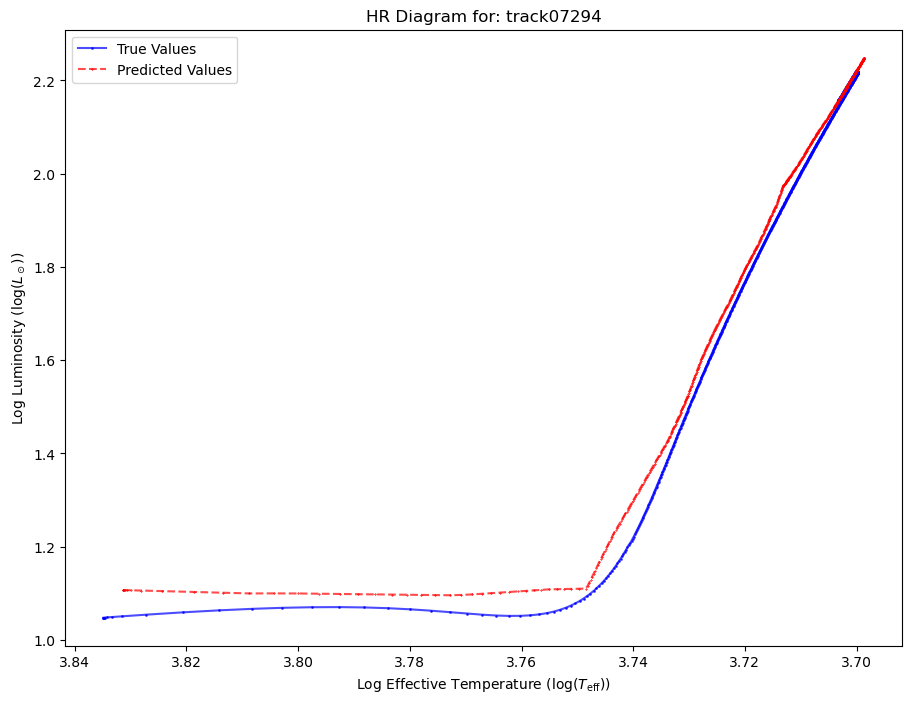

In [247]:
import jax.numpy as jnp
import h5py
import torch
import matplotlib.pyplot as plt

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = jnp.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Outputs
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]
    dnufit_specific = specific_track['dnufit'][:]
    FeH_specific = specific_track['FeH'][:]
    G_GAIA_specific = specific_track['G_GAIA'][:]
    massfin_specific = specific_track['massfin'][:]
    numax_specific = specific_track['numax'][:]
    MeH_specific = specific_track['MeH'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]


# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Convert `all_features` to numpy array before scaling
all_features_numpy = np.array(all_features)  # Convert to numpy for scaling
all_features_scaled = scaler_X.transform(all_features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific1 = model(all_features_tensor).numpy()  # Make predictions
    predictions_specific = scaler_y.inverse_transform(predictions_specific1)  # Inverse transform
# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]

print(predictions_specific1[0])

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()



In [248]:
import jax
import jax.numpy as jnp

def emulate_with_pytorch(x, model):
    # Normalize inputs

    # Convert to PyTorch tensor
    x_tensor = torch.FloatTensor(x)

    # Pass through PyTorch model
    model.eval()
    with torch.no_grad():
        y_specific = model(x_tensor)

    y = y_specific
    return y  
    

In [249]:

state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x





In [250]:
obs = {
    'teff': teff_specific,
    'lum': luminosity_specific,
    'dnu': dnufit_specific,
    'feh': FeH_specific,
    'gaia': G_GAIA_specific,
    'mass': massfin_specific,
    'numax': numax_specific,
    'meh': MeH_specific
}


In [251]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.deterministic('ages_', 300 * numpyro.sample("ages_s", dist.Beta(2, 2)) + 4000) 
    massini_ = numpyro.deterministic('massini_', 0.002 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 1.107)  
    fehini_ = numpyro.deterministic('fehini_', 0.02 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 1.15539551)  
    alphamlt_ = numpyro.deterministic('alphamlt_', 0.02 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 2.02275391) 
    yini_ = numpyro.deterministic('yini_', 0.002 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.24572388)  
    eta_ = numpyro.deterministic('eta_', 0.0002 * numpyro.sample("eta_s", dist.Beta(2, 2)) + 0.03665771)  
    alphafe_ = numpyro.deterministic('alphafe_', 0.02 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.21)  



    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, alphafe_]
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.stack(log_transformed_inputs + [fehini_, yini_], axis=-1)
    x = x.reshape(-1, 7)


    # Emulate using PyTorch model
    y_scaled = emulate(x) # , model, scaler_X, scaler_y
    
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y

    # Extract predictions
    teff, lum, dnu, feh, gaia, mass, numax, meh = (
        y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4], y[:, 5], y[:, 6], y[:, 7]
    )

    #print(teff, lum, dnu, feh, gaia, mass, numax, meh) 
    # predictions should be: [ 3.8313274   1.1070768   1.5240705   0.22732672  0.02866789 -0.83310765
    # -1.3271372  -1.3964001 ]

    

    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, 50.0), obs=teff_specific)
        numpyro.sample("lum_obs", dist.StudentT(3, lum, 0.05), obs=luminosity_specific)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, 0.8), obs=dnufit_specific)
        numpyro.sample("feh_obs", dist.StudentT(4, feh, 0.02), obs=FeH_specific)
        numpyro.sample("gaia_obs", dist.StudentT(3, gaia, 0.01), obs=G_GAIA_specific)
        numpyro.sample("mass_obs", dist.StudentT(6, mass, 0.6), obs=massfin_specific)
        numpyro.sample("numax_obs", dist.StudentT(4, numax, 0.02), obs=numax_specific)
        numpyro.sample("meh_obs", dist.StudentT(4, meh, 0.02), obs=MeH_specific)


In [252]:
from jax import random
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8,
            init_strategy=init_to_median,  
            find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4)
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_27372\1851821253.py:7: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 4000/4000 [00:13<00:00, 286.74it/s, 7 steps of size 5.78e-01. acc. prob=0.91]


In [253]:
import arviz as az

trace = az.from_numpyro(mcmc)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_,4001.238,0.891,4000.014,4002.766,0.008,0.006,11818.0,5141.0,1.0
ages_s,0.004,0.003,0.000,0.009,0.000,0.000,11816.0,5136.0,1.0
alphafe_,-0.200,0.004,-0.208,-0.192,0.000,0.000,13689.0,5162.0,1.0
alphafe_s,0.503,0.220,0.107,0.889,0.002,0.001,13689.0,5162.0,1.0
alphamlt_,2.041,0.001,2.038,2.043,0.000,0.000,11612.0,5272.0,1.0
alphamlt_s,0.898,0.071,0.767,0.997,0.001,0.000,11612.0,5272.0,1.0
eta_,0.037,0.000,0.037,0.037,0.000,0.000,13346.0,5105.0,1.0
eta_s,0.500,0.225,0.097,0.890,0.002,0.002,13346.0,5105.0,1.0
fehini_,-1.136,0.000,-1.136,-1.135,0.000,0.000,10941.0,5130.0,1.0
fehini_s,0.993,0.005,0.984,1.000,0.000,0.000,10941.0,5156.0,1.0


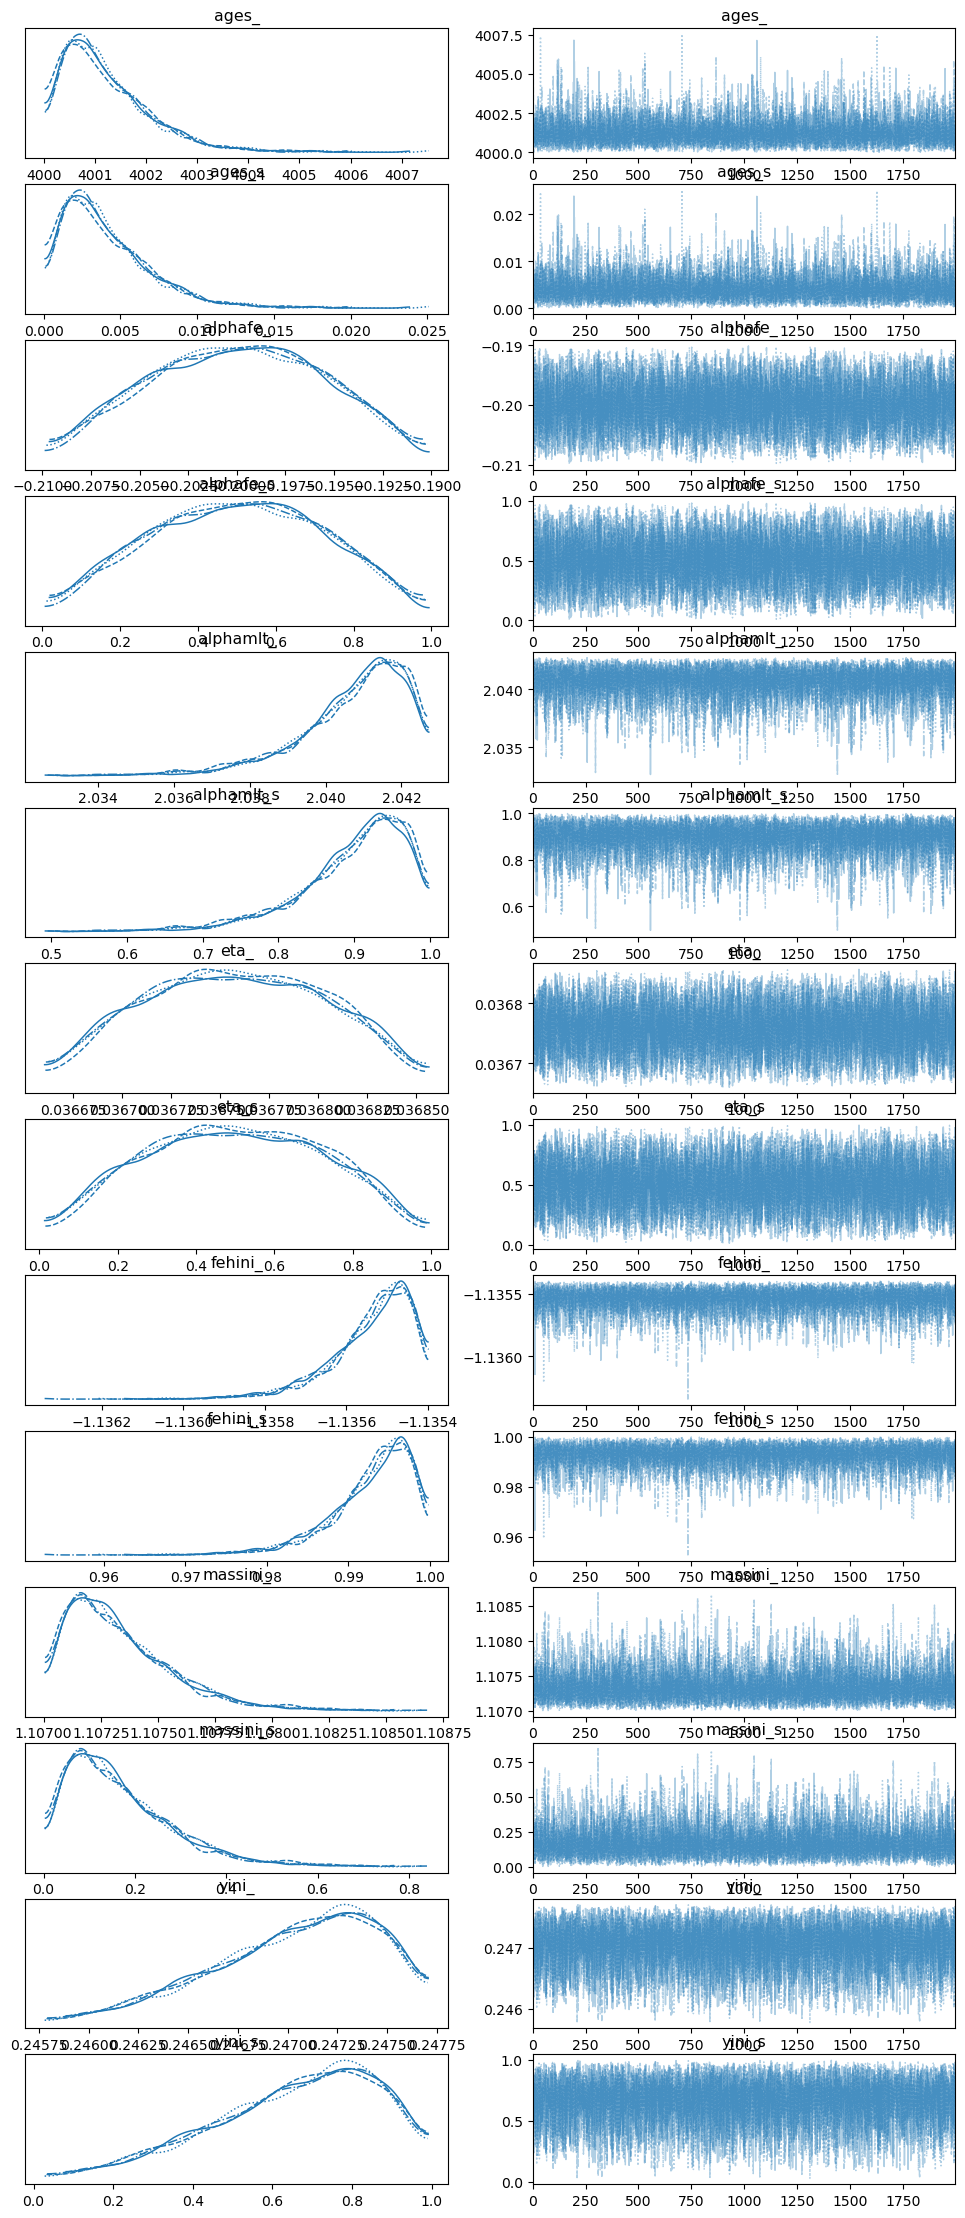

In [254]:
az.plot_trace(trace);

In [255]:
truth_values = [ages[0].item(), massini[0].item(), alphamlt[0].item(), eta[0].item(), yini[0].item(),  fehini[0].item(), alphafe[0].item()]
print(truth_values)

[4145.349646, 1.107, 2.02275391, 0.0366577148, 0.245723877, -1.15539551, -0.2]


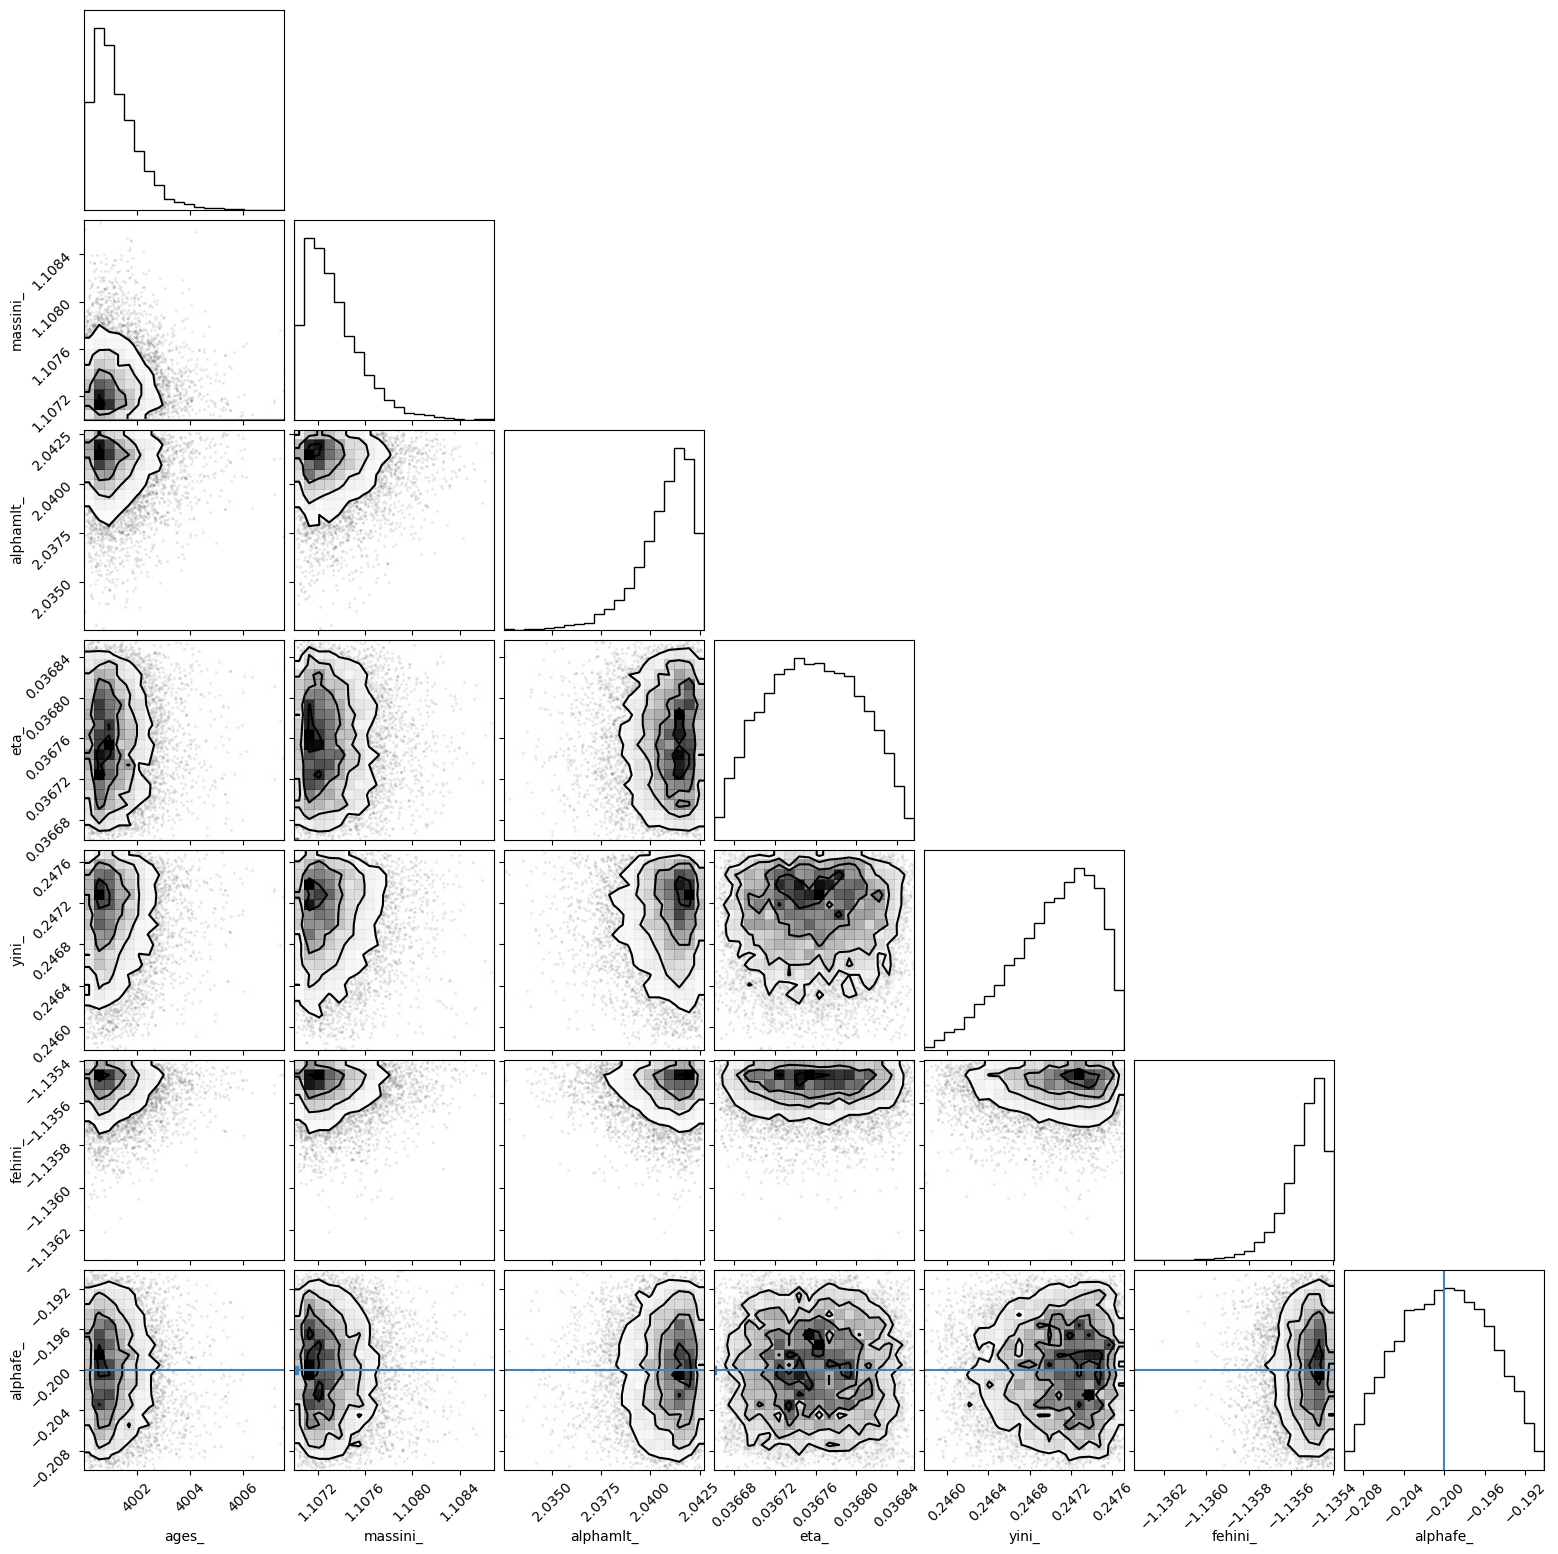

In [256]:
import corner

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truth_values
             );

In [257]:
# Extract the variables from the trace
ages_samples = trace.posterior['ages_'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()

# Randomly sample 910 indices
selected_indices = np.random.choice(len(ages_samples), size=910, replace=False)

# Subsample all variables
ages_subsample = ages_samples[selected_indices]
mass_subsample = mass_samples[selected_indices]
mlt_subsample = mlt_samples[selected_indices]
eta_subsample = eta_samples[selected_indices]
yini_subsample = yini_samples[selected_indices]
fehini_subsample = fehini_samples[selected_indices]
fe_subsample = fe_samples[selected_indices]


features = np.hstack((ages_subsample, mass_subsample, mlt_subsample, eta_subsample, yini_subsample, fehini_subsample, fe_subsample)).reshape(-1, 7)
features_tensor = torch.FloatTensor(features)

print(features)


[[ 4.0019219e+03  4.0002502e+03  4.0011011e+03 ...  4.0009478e+03
   4.0017400e+03  4.0021338e+03]
 [ 4.0018704e+03  4.0001125e+03  4.0014871e+03 ...  4.0011138e+03
   4.0010103e+03  4.0037966e+03]
 [ 4.0005552e+03  4.0003755e+03  4.0007258e+03 ...  4.0007871e+03
   4.0011807e+03  4.0019697e+03]
 ...
 [-1.9406362e-01 -2.0155692e-01 -2.0628220e-01 ... -1.9966750e-01
  -2.0123760e-01 -2.0683664e-01]
 [-1.9570510e-01 -2.0235853e-01 -2.0096993e-01 ... -1.9434734e-01
  -1.9523291e-01 -1.9700368e-01]
 [-1.9596708e-01 -2.0127377e-01 -2.0796010e-01 ... -1.9616768e-01
  -2.0201899e-01 -2.0167825e-01]]


[751.52997   750.7611    752.15      749.9701    749.1834    753.2712
 750.47845   750.396     751.86066   747.1874    750.4317    748.02234
 747.0573    751.11017   753.90265   753.4327    754.4438    750.4386
 749.9941    750.0576    752.79364   751.81366   753.0339    749.1687
 749.5942    752.2605    752.08765   750.2231    752.9926    753.91223
 750.8505    748.9224    752.88      754.5555    752.872     752.7208
 757.989     751.79443   753.01385   750.7403    752.17114   754.24585
 751.0725    752.47253   751.36224   751.3311    754.5098    750.4833
 751.7966    751.07135   752.9105    748.1922    751.7926    750.92017
 752.9113    750.53986   750.201     751.8405    752.2549    749.3077
 750.12805   749.81415   755.6214    750.17163   751.64056   756.62714
 757.2111    754.7565    751.6593    752.2719    749.45447   750.04565
 752.85095   750.2495    752.53906   752.04047   751.83545   751.91046
 752.8761    754.9318    751.8189    752.9286    754.0289    748.78723
 751.70276  

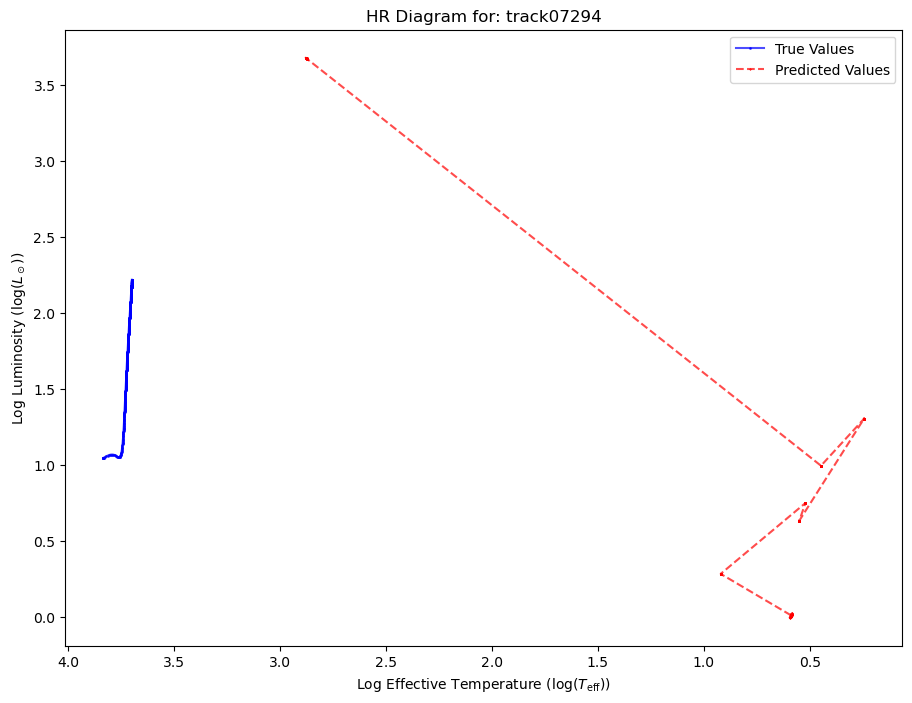

In [258]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = abs(predictions_hbm[:, 0])  # Inverse log10 transformation
hbm_luminosity = abs(predictions_hbm[:, 1])

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

print(hbm_teff)
print(len(log_actual_teff))

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()